<a href="https://colab.research.google.com/github/VetrovSV/ml-files/blob/main/%5Bopen_data_battle%5Dfinal_task_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача по прогнозированию ошибки модели оценки вероятности дефолта (MPP)

 Мы долго работали и построили модель оценки вероятности дефолта (PD модель). Все работает прекрасно, но нужно контролировать качество этой базовой модели и оценивать ошибку, индуцированную базовой моделью, поэтому нам нужно разработать модель прогнозирования ошибки (MPP). Ошибка в нашем случае - это разница между флагом flg_90_12_add, представляющим собой реализованное событие (0 - не дефолт, 1 - дефолт) и значением PD, представляющим собой оценку от нашей базовой модели.


Таким образом, Вам необходимо обучить модель прогнозирования ошибки с использованием двух датасетов и предсказать метрику |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN. 

Исходные файлы:

- data.csv — данные об экспериментах (incident), включая большое количество признаков и флаг flg_90_12_add, представляющий собой реализованное событие (0 - не дефолт, 1 - дефолт)
- model.csv — результаты прогнозирования дефолта (PD), полученные в нашей разработанной модели
- sample_submission.csv — пример файла, который необходимо отправить 


Результаты решения прикрепите в CSV формате. Файл должен содержать только прогнозные значения |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN, в одном столбце без заголовка. В качестве оценки решения будет использоваться характеристика MAE. 

 Решения можно отправлять неоднократно, фиксироваться будет наилучшее.

Скорость решения не учитывается.

In [ ]:
# !unzip /content/drive/MyDrive/ML/open-data-battle.geecko.com/mpp.zip

In [12]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

import imblearn

# Загрузка данных

In [13]:
data0_pred = pd.read_csv("model.csv")

In [14]:
data0 = pd.read_csv("data.csv")     
print( data0.info() )   # 1.2+ GB
data0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82617 entries, 0 to 82616
Columns: 1910 entries, incident to Feature_1887
dtypes: float64(1837), int64(72), object(1)
memory usage: 1.2+ GB
None


,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,Category_Feature_8,Category_Feature_9,Category_Feature_10,Category_Feature_11,Category_Feature_12,Category_Feature_13,Category_Feature_14,Category_Feature_15,Category_Feature_16,Category_Feature_17,Category_Feature_18,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,...,Feature_1848,Feature_1849,Feature_1850,Feature_1851,Feature_1852,Feature_1853,Feature_1854,Feature_1855,Feature_1856,Feature_1857,Feature_1858,Feature_1859,Feature_1860,Feature_1861,Feature_1862,Feature_1863,Feature_1864,Feature_1865,Feature_1866,Feature_1867,Feature_1868,Feature_1869,Feature_1870,Feature_1871,Feature_1872,Feature_1873,Feature_1874,Feature_1875,Feature_1876,Feature_1877,Feature_1878,Feature_1879,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,2.0,35000.0,0.0,0.0,1.0,0.0,2.0,7.0,4.0,28.0,6.0,3.0,NaN,NaN,NaN,0.225000,0.175000,0,0,1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.053696,5.053696,5.053696,5.053696,5.053696,5.053696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,20184
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,2.0,50000.0,0.0,0.0,0.0,0.0,2.0,7.0,5.0,23.0,3.0,4.0,NaN,NaN,NaN,0.333333,0.166667,0,0,7,1,0,0,0,4,1,0,0,0,3,...,1.901645,1.0,12969.251635,27353.234548,14383.982913,14383.982913,0.474140,0.901645,0.901645,1.901645,1.901645,1.0,0,0.526316,0.526316,0.600000,0.600000,0.526316,0.526316,0.043231,0.091177,0.047947,0.047947,0.043231,0.091177,0.047947,0.047947,0.129693,0.273532,0.14384,0.14384,0.259385,0.547065,0.28768,0.28768,0,1,1,1,20184
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,1.0,20000.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253165,0.253165,0,1,10,2,2,0,1,10,5,2,0,1,8,...,NaN,NaN,8406.411307,4853.739804,NaN,NaN,1.731945,NaN,NaN,NaN,NaN,NaN,0,1.128571,1.128571,0.790000,0.790000,0.087778,0.087778,0.106410,0.061440,NaN,NaN,0.106410,0.061440,NaN,NaN,0.420321,0.242687,NaN,NaN,0.420321,0.242687,NaN,NaN,0,1,0,1,20184
3,14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,2.0,30000.0,0.0,0.0,0.0,0.0,2.0,7.0,1.0,32.0,1.0,4.0,NaN,NaN,NaN,0.650000,0.150000,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20184
4,14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,3.0,50000.0,0.0,0.0,1.0,0.0,2.0,7.0,5.0,22.0,5.0,4.0,NaN,NaN,NaN,0.900000,0.250000,0,1,3,3,0,0,1,3,4,0,0,1,3,...,NaN,NaN,2293.148913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.883465,2.883465,10.473946,10.473946,0.188679,0.188679,0.011466,NaN,NaN,NaN,0.011466,NaN,NaN,NaN,0.012740,NaN,NaN,NaN,0.045863,NaN,NaN,NaN,0,1,0,1,20184


In [15]:
# порядок данных в файлах совпадает
assert (data0['incident'] == data0_pred['incident']).sum() == len(data0)

# но для примера используем соединение таблиц по полю incident: 
# left outer join - смотреть на левую таблицу, добавлять такие же строки в правую
data0 = data0.merge(data0_pred, on='incident', how='left')

In [ ]:
# при необходимости, можно уменьшить размер датасета заменив типы на более компактные
# 4+ minutes
for col in data0.columns:
    # тут в data0 почти везде float, потмоу что int не может хранить NaN
    if data0[col].dtype == 'float64':
        data0[col] = data0[col].astype(np.float32)
print( data0.info() )                                           # 625.0+ MB

## Анализ и предобработка

In [ ]:
data0.isna().sum()            # пропусков -- дофига

### Анализ переменных

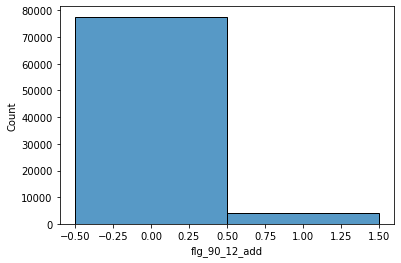

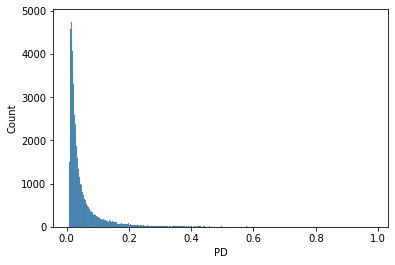

target = 1 : 4032  ( 4.94 % )


In [33]:
seaborn.histplot( data0['flg_90_12_add'], discrete=True )
plt.show()
seaborn.histplot( data0_pred['PD']  )
plt.show()
class_1 = (data0['flg_90_12_add']==1).sum()
class_1_perc = class_1 / (len(data0)-1000) * 100

print(f"target = 1 : { class_1 }  ( {class_1_perc:4.2f} % )")

# большой дизбаланс классов, но это задача регресии, где y = | PD - flg_90_12_add |
# не красивое распределение y. надо логарифмировать чтобы убрать длинный хвост справа

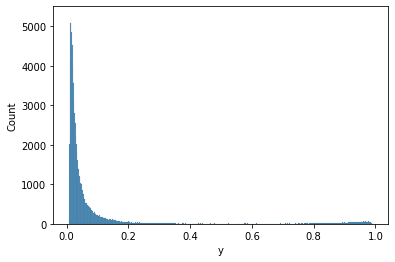

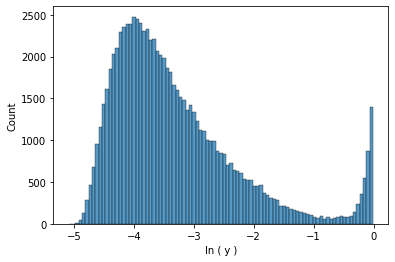

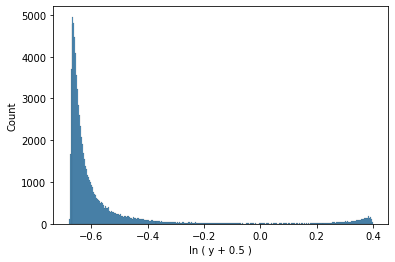

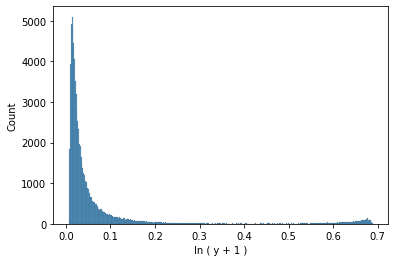

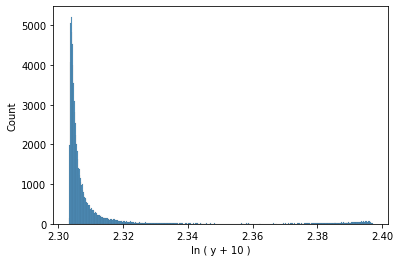

In [34]:
# анализ разных преобразований целевого признака
y = np.abs(data0_pred['PD'] - data0['flg_90_12_add'])

seaborn.histplot( y )               
plt.xlabel('y')
plt.show()


seaborn.histplot( np.log( y ) )                         # выглядит более сносно чем остальные. подтвержается лучшим сабмитом
plt.xlabel('ln ( y )')
plt.show()

seaborn.histplot( np.log(y+0.5) )          
plt.xlabel('ln ( y + 0.5 )')
plt.show()


seaborn.histplot( np.log(y+1) )            
plt.xlabel('ln ( y + 1 )')
plt.show()
   
seaborn.histplot( np.log(y+10) )           
plt.xlabel('ln ( y + 10 )')
plt.show()

In [ ]:
# Эти фичи (и ещё другие, но их лень приводить) были отобраны кэтбустом как выжные 
# Category_Feature_1
# Category_Feature_2            # лог? возможно
# Feature_962                   # np.log(-data1['Feature_962']+1)
# Feature_960                   # np.log( -data1['Feature_960']+1 )
# Feature_959

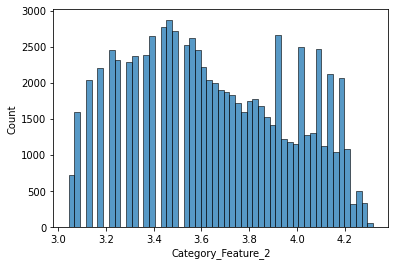

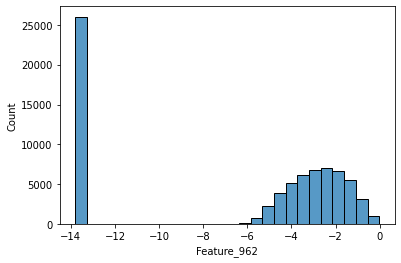

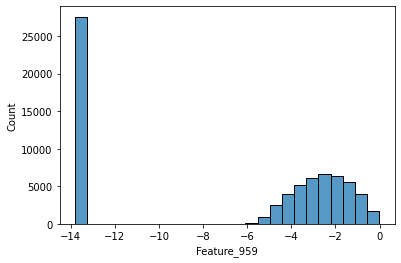

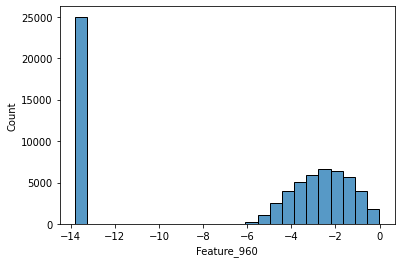

In [ ]:
# проверим как меняются распределения. потом преобразуем

# seaborn.histplot(         data0['Category_Feature_2'] )           # похоже на возраст. хвост справа. логарифмировать
# data0['Category_Feature_2'].isna().sum()                            # пропусков нет!
seaborn.histplot( np.log( data0['Category_Feature_2'] ) )               # лучше же?
plt.show()
# seaborn.histplot( data0['Feature_962'] )                          # большой хвост слева
seaborn.histplot( np.log(-data0['Feature_962']+1.000001) )                   # сделать отрицательным (равернуть), сделать положительным (чтобы лог. сработал), логарифмировать  
plt.show()
# seaborn.histplot( data0['Feature_959'] )                          # большой хвост слева
seaborn.histplot( np.log(-data0['Feature_959']+1.000001) )                   # ...
plt.show()
# seaborn.histplot( data0['Feature_960'] )                          # большой хвост слева
seaborn.histplot( np.log(-data0['Feature_960']+1.000001) )
plt.show()

# далее запишим эти преобразования в датафреим

### Категориальные признаки

In [ ]:
data0[ data0.columns[3:3+19] ].isna().sum(axis=0)

Category_Feature_0        22
Category_Feature_1         0
Category_Feature_2         0
Category_Feature_3      3809
Category_Feature_4      3809
Category_Feature_5         0
Category_Feature_6         0
Category_Feature_7       284
Category_Feature_8       284
Category_Feature_9       284
Category_Feature_10      284
Category_Feature_11      284
Category_Feature_12      284
Category_Feature_13     4307
Category_Feature_14     4307
Category_Feature_15     4307
Category_Feature_16     4307
Category_Feature_17    14786
Category_Feature_18     4307
dtype: int64

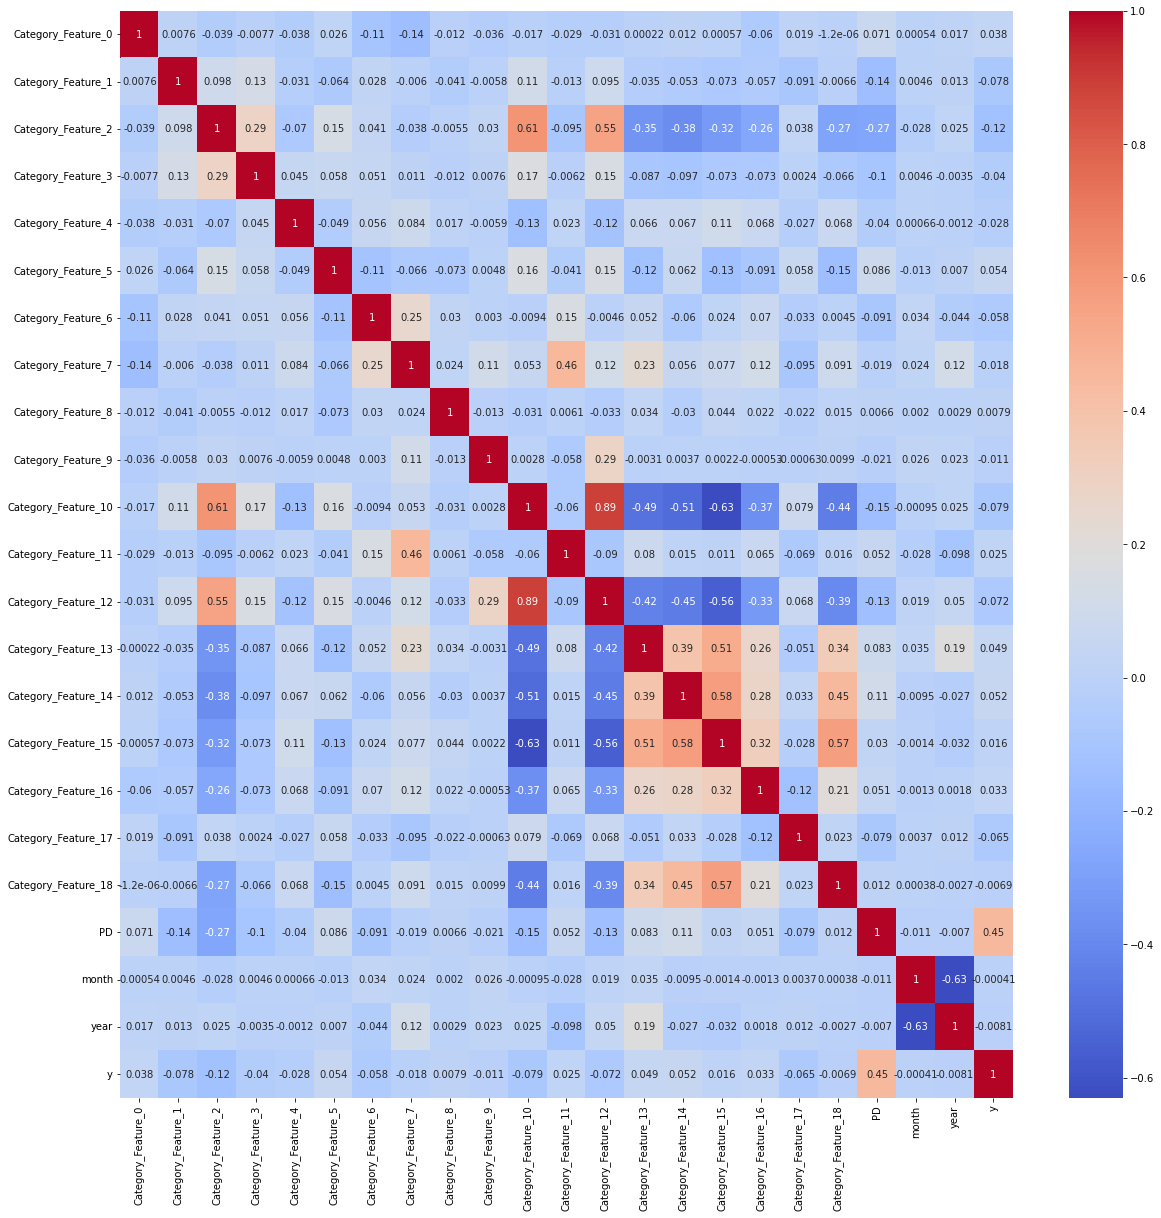

In [ ]:
# запустить эту ячейку после предобработки (см. ниже)
# потом, в предобработку, добавим заполнение пропусков в этих признаках основываясь на корреляции (IterativeImputer)
cats = [f'Category_Feature_{i}' for i in range(19)] + ['PD', 'month', 'year', 'y']

plt.figure( figsize=(20,20) )
seaborn.heatmap( data1[cats].corr(), annot=True, cmap='coolwarm' )

### Преобразования

In [16]:
def preprocess_all(data0, data0_pred,  min_missing = 0.25):
    """ Начальная преобработка всех данны (Треин и Тесты):
    - удаление столбцов с пропусками (где больше чем в min_missing)
    - заполниение остальных пропусков
    - перевод даты в месяц, год
    - вычисление целевого признака (без. лог модификации)
    
    min_missing -- столбцы, где доля пропусков > выкидываем"""
    # заполнение 0.7 столбцов пропусками -- рабоает (немного)
    data = data0.copy()
    # вероятно число пропусков как-то влияло на PD (ошибку модели). учтём это
    data['nan_count'] = np.isnan (data.drop(columns='APPLICATION_MONTH').values).sum(axis=1)
    
    missing = data.isna().sum().values
    missing = missing > len(data)*min_missing                                   # если в столбца пропущено больше этой доли всех, то удалим его
    print(f"Столбцов с большим числом пропусков  {missing.sum()}")
    print(f"Столбцов остальных (включая целевой) {len(data.columns) - missing.sum()}")
    missing = data.isna().sum()[ missing ]

    data = data.drop(columns = missing.index.values )
    
    data['month'] = data['APPLICATION_MONTH'].apply( lambda x: int(x[ -2: ]))
    data['year'] =  data['APPLICATION_MONTH'].apply( lambda x: int(x[ :4 ]))

    # для интеллектуальной замены пропусков в категориальных признаках
    # cat_forest = RandomForestClassifier()
    # cat_imputer = IterativeImputer(cat_forest)
    cat_imputer = IterativeImputer()
    cats = [f'Category_Feature_{i}' for i in [1,5,6,10,12, 17]] + ['month', 'year']
    # берём только столбцы с более-менее большой корреляцией с PD.              # todo: посмотреть на значимость физ их кэтбуста
    data_cat = data[cats] # .astype(np.int64)
    # сначала заменит пропуски в одном столбце, не освнове похожести (лес) на другие,
    # потов на втором столбце, уже пользуясь инфой с 
    data[cats] = cat_imputer.fit_transform( data_cat )

    # замена пропусков в остальных категориальных признаках
    for i in range(19):
        col = f'Category_Feature_{i}'
        if col in data.columns:
            data[col].fillna( stats.mode( data[col] ).mode[0], inplace=True )

    # todo: тут тоже стоит свою интеллектуальную замену для значимых признаков сделать
    for col in [f'Feature_{i}' for i in range(1888)]:
        if col in data.columns:
            data[col].fillna( np.nanmedian(data[col]), inplace=True )           # nanmedian -- медиана, которая умеет пропускать nan
            data[col] = data[col].astype(np.float32)                            # замена типов на более экономичные. 1.2Gb -- для фрайма многовато )
    
    # эти столбцы (как выяснил кэтбуст) важны. поэтому сделаем их распределение более нормальным
    data['Category_Feature_2'] =np.log( data['Category_Feature_2'] )
    data['Feature_962'] =       np.log(-data['Feature_962']+1.000001)           # .000001 -- чтобы не было -inf после логарифмирования нуля
    data['Feature_959'] =       np.log(-data['Feature_959']+1.000001)
    data['Feature_960'] =       np.log(-data['Feature_960']+1.000001)

    data['y'] = np.abs(data0_pred['PD'] - data0['flg_90_12_add'])

    # подчитстим лишнее
    data.drop(columns = ['flg_90_12_add',
                          'PD', 
                         'APPLICATION_MONTH'], inplace=True)

    return data

In [17]:
# 50 s
# удалим все признаки где более этой доли пропусков
min_missing = 0.7
# как выяснилось удаление столбцов с долей пропусков ниже 0.7 делает скор хуже
# потом ещё из них можно отобрать самые значимые и переобучится
# todo: возможно границу стоит повысить

data1 = preprocess_all(data0, data0_pred, min_missing) 
selected_columns = data1.drop(columns='y').columns                                   # запомним столбцы, которые остались

missing2 = data1['y'].isna().sum()
print( missing2.sum() )

assert missing2.sum() == 1000                   # чтобы случайно не заполнить пропуски таргета на тесте

# print( data1.columns.values )

Столбцов с большим числом пропусков  1202
Столбцов остальных (включая целевой) 710
1000


In [18]:
# 2-4 минуты
# проверка на выбросы
# добавим число выбросов как фичу; они тоже могли влять на ошибку базовой модели, которую мы предсказываем

# todo: посмотреть кластеризацю. арганизаторы говорили, что выкинули какой-то кластер
# todo: добавить кластер как новый признак??

def check_outliers(data, k=3):
    """ Проверка на выбросы
    k -- число допустимых отступов от среднего
    """
    Means = {}
    Stds = {}
    outliers = 0            # число столбцов с выбросами
    for col in data.columns:
        mean = data[col].mean()
        std = data[col].mean()
        Means[col] = mean
        Stds[col] = std
        outliers = np.abs( data[col]-mean ) > k*std
        print(f"{col:25s}   -   {outliers.sum()}")

    return Means, Stds, outliers


def check_outliers_inrow(row, colnames, Means, Stds, k=3):
    """ провесряет есть ли в текущей строке выбросы """
    outliers = 0
    for i, col in enumerate( colnames ):
        mean = Means[col]
        std = Stds[col]
        if np.abs(row[i] - mean) > std*k:
            outliers += 1
    return outliers        


Means, Stds, outliers = check_outliers(data1, k = 5)

print(f"Cols with outliers  {outliers}")

Outliers = np.zeros(len(data1) )
for i in range(len(data1)):
    Outliers[i] = check_outliers_inrow(data1.iloc[i,:], data1.columns, Means, Stds)

data1['Outliers'] = Outliers
print(f"mean outliers in row  {data1['Outliers'].mean():.2f}")
print(f"rows with no outliers {(data1['Outliers']==0).sum()}")



incident                    -   0
Category_Feature_0          -   0
Category_Feature_1          -   0
Category_Feature_2          -   0
Category_Feature_3          -   0
Category_Feature_4          -   232
Category_Feature_5          -   0
Category_Feature_6          -   0
Category_Feature_7          -   0
Category_Feature_8          -   728
Category_Feature_9          -   1875
Category_Feature_10         -   0
Category_Feature_11         -   10335
Category_Feature_12         -   0
Category_Feature_13         -   0
Category_Feature_14         -   0
Category_Feature_15         -   0
Category_Feature_16         -   0
Category_Feature_17         -   0
Category_Feature_18         -   0
Feature_0                   -   122
Feature_1                   -   680
Feature_2                   -   616
Feature_3                   -   200
Feature_4                   -   757
Feature_5                   -   10112
Feature_6                   -   2850
Feature_7                   -   304
Feature_8         

In [ ]:
# для предварительной оценки значимости признаков
# далее будем брать важность признаков из кэтбуста,

from scipy.stats import pearsonr

good_features = []
for i, col in enumerate(data1.columns):
    r,p = pearsonr(data1['y'].iloc[:-1000], data1[col].iloc[:-1000])
    if (np.abs(r) > 0.1): 
        sign = "*"
        good_features += [ col ]
    else: sign = ""
    print(f"{i}: {col:20s}   -   {r:7.4f}    {sign}")

In [41]:
C = 0           # прибавление 1 делает распределение Y таким же ненормальным как и сам Y; просто ln -- сносно

def convert_y(y, c = C):
    """ преобразует целевой признак """
    return np.log(y + c)
    # return y

def inv_convert_y(y, c = C):
    return np.exp(y) - c
    # return y


def preprocess_to_train_test(data, features_whitlst = None):
    """
    Делет всё на части. X_train, X_test сразу масштабирует;
    X (из которого они набирались) возвращает как есть, далее будем учить на нём финальную модель
    y лоарифмить будем позже, при применении модели. чтобы применять convert только в одном месте
    """
    for col in [f'Feature_{i}' for i in range(1888)]:
        if col in data.columns:
            if data0[col].dtype == 'float64':
                # заменять на более компактный тип лучше посли фильтрации столбцов
                # иначе долго ждать.
                # todo: перенести в preprocess_all
                data[col] = data[col].astype(np.float32)                        

    Test  = data[  data['y'].isna() ]
    Train = data[ ~data['y'].isna() ]
    
    print(f"Test size =  {len(Test):7d}")
    print(f"Train size = {len(Train):7d}")
    print()
    
    y = Train['y'].values
    X = Train.drop( columns=['y']).values
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1729)

    # для контроля
    print()
    print("Данные для обучения и оценки на тесте")
    print(f"train size = {len(y_train):7d}")
    print(f"test size =  {len(y_test):7d}")

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X,y, Test, scaler
    # X,y - для дальнейшего обучения на всех известных данных; не масштабированы
    # обучение только на части изветных данных, в теории уменьшит скор

    

X_train, X_test, y_train, y_test,  X,y, Test, scaler = preprocess_to_train_test(data1)
print(f"features = {X_train.shape[1]}")
assert len(Test) == 1000                    # контроль: случано не потерять Тест

Test size =     1000
Train size =   81617


Данные для обучения и оценки на тесте
train size =   65293
test size =    16324
features = 710


In [68]:
# контроль: какие фичи добавлены
data1.columns[-6:]

Index(['Feature_1887', 'nan_count', 'month', 'year', 'y', 'Outliers'], dtype='object')

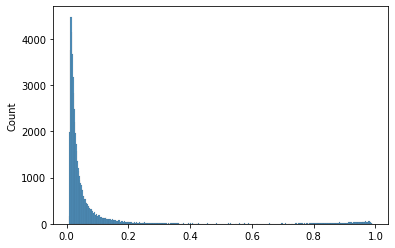

In [20]:
# контроль: y_train должен быть исходным, без логарифма -- график с пиком слева
seaborn.histplot( y_train )

In [21]:
# сколько осталось от 1.2 Gb датасета?
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82617 entries, 0 to 82616
Columns: 711 entries, incident to Outliers
dtypes: float32(686), float64(23), int64(2)
memory usage: 232.6 MB


# Модели

In [22]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_percentage_error            # есть только в новом sklearn

# использовалось для контроля: 
# при логарифмировании таргета, если забыть обратное преобразование MAE взлетает: y (0..1] -> [-5, 0)
# относительная ошабка MAPE будет сильно отличатся от MAE если где-то преобразование забыл сделать
def MAPE(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100


def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print( np.isnan( y_pred ).sum() )
    y_pred = inv_convert_y(y_pred)                        # обратное преобразование (см. preprocess_to_train_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'mae = {mae:.5f}; mape = {MAPE(y_test, y_pred):.5f}')
    return mae

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso,  ElasticNet
from sklearn.svm import SVR             # очень долго. 40+ минут. не досчитал

from sklearn.metrics import mean_absolute_error

## LinReg

In [25]:
# даёт нормальный результат когда не очень много (порядка 100) фич, 
# но сильно хуже когда фич много. 
# тоже иногда полезно использовать для контроля
# иногда даёт бешенный MAE (сильные корреляции в фичах?)
linreg = LinearRegression()

linreg.fit(X_train, y_train)
print(X_train.shape[1])     # снова контроль. 

710


In [26]:
mae = test_model(linreg, X_test, y_test)
# mae раньше писалось в имя файла сабмита

0
mae = 1.00554; mape = 100.55441


## CatBoost

In [28]:
!pip install pytelegrambotapi -q
!pip install catboost -q

In [49]:
# показал себя лучше остальных
import catboost as cb

# эти параметры уже подобраны
parameters = {'depth'        : [6],     # 4, 6, 8
             'learning_rate' : [0.1],   # 0.001, 0.01, 0.1      
             'iterations'    : [2000],  # число деревьев
             'l2_leaf_reg'   : [9],     # 3, 9, 20
                 }

cat = cb.CatBoostRegressor( loss_function='MAE',
                            eval_metric='MAE',
                            random_seed = 167, 
                            od_type='Iter',
                            od_wait=50,
                            iterations=2000,            # тут дублируется число
                            #  task_type="GPU", devices='0:1'  рантайм крашится :(  а на локальной карте памяти мало
                             )

grid_search_result = cat.grid_search(parameters, 
                                       cv = 3,
                                       X=X_train, 
                                       y=y_train)

In [ ]:
grid_search_result['params']

{'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 9, 'learning_rate': 0.1}

 > 0.01 462


array([ 99, 374, 378, 160, 365, 146, 393, 300, 367, 188, 153, 307, 138,
        69, 433, 241,  85, 240, 344, 162, 402, 435, 215,  78, 299,  83,
       429, 139, 330, 422,  77, 347, 210, 420, 421, 419, 200,  48, 363,
       232, 360, 234, 277, 191, 361, 351, 122,  91, 350, 147, 270, 354,
       231, 194, 318, 305, 264, 155, 111, 117, 214,  79, 303, 428,  95,
       297, 325, 142,  52, 415,  43, 352, 377,  55, 135, 145, 116, 386,
       414, 423, 108, 282, 206,  84, 193, 173, 353, 312, 150, 355, 136,
        41,  88, 372, 410, 275, 411, 106, 379, 248, 258, 267, 304, 202,
        26, 346, 326, 446, 255,  97,  98, 178, 271, 179, 102, 203, 164,
        68,  46, 449, 334, 189, 301, 119, 381, 311, 156, 187, 436, 140,
       154, 130,  89, 407, 314, 366, 443, 175, 126, 134, 292, 333, 123,
       430, 151, 152, 404, 370,  13, 359, 229, 204,  81, 238, 168, 418,
       413,  59, 249,  31, 329, 109, 409, 387, 364, 218, 357, 373, 224,
       207, 260, 233, 228, 157, 296, 405, 371, 336, 159,  93,  5

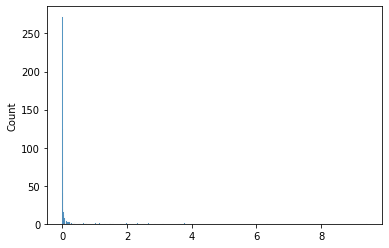

In [53]:
# значимость фич. чем больше -- тем больший вклад фича даёт в результат предсказания

# можно потом через f_imp отобрать фичи и заново обучить

f_imp = cat.get_feature_importance()            
seaborn.histplot( f_imp )
th = 0.005                                          # минимальная значимость фичи
print( f" > {th:.2f} { (f_imp > th).sum() }" )
f_imp = f_imp[ f_imp > th]                          # 100 самых важных фич (самые важные -- в конце)
f_imp = f_imp.argsort()                             # отсортируем (по возрастанию) зачем-то

f_imp

In [35]:
# X_train = X_train[:, f_imp]
# X_test =  X_test[:, f_imp]

In [61]:
# 710 + outliers
# f_imp = array([ 92, 276, 231, 117, 142, 315, 108, 116, 102,  73, 299, 233, 267,
    #    322, 132,  98, 106, 220, 248,  95, 311, 114, 115, 296, 270,  13,
    #    264, 172, 151,  69, 178, 126, 306, 303,  52, 186,  30, 245,  85,
    #    301, 281, 266, 161, 262, 272, 167, 153, 195, 174, 171, 118, 224,
    #    297, 271, 250, 120,  76,  47, 211, 157,  83, 223, 263,  75, 246,
    #     68, 105, 127, 110, 162,  71, 292, 112, 111, 179, 125, 144, 327,
    #    286, 109, 119, 314, 334, 305, 166, 128, 150, 164,  23, 193, 265,
    #    210,  28, 107, 139, 155,  96, 318, 261, 203, 325, 130, 222, 243,
    #    104,  70, 131, 148,  72, 213, 274, 229, 328, 206, 146,  42, 244,
    #    236, 183, 255, 204,  77,  60, 227,  78, 159, 298,  33, 324,  31,
    #     86, 138, 190, 163, 208, 329, 121,  89, 154, 160, 247, 143, 284,
    #     67,  58, 152, 273,  94, 129, 302, 168, 214, 123,  93,  43,  91,
    #    122,  74, 300, 180, 134, 275, 156, 202,  41, 136, 252, 124, 310,
    #    141, 279, 113, 285, 188, 277, 133, 304, 260, 312, 269, 149, 145,
    #    321,  27,  55, 294,  25, 170, 207, 173, 254, 326, 323, 290, 169,
    #    182,  36,  50,  32, 337, 282, 205, 135, 212,  44, 280, 197, 137,
    #    259,  99, 239, 287, 165,  48, 268, 228, 101, 336, 232,  39,  26,
    #    237, 216, 234, 253,  59, 249,  62,  97,  90, 288, 199, 225, 283,
    #      8, 158, 240, 313, 226, 187,  65, 242, 256,  79, 289,   5,  45,
    #    320,  64, 100,  20,  46,  40, 251, 217, 201, 103, 235, 317, 238,
    #    241, 319, 147,  35,  29, 209,  66,  19,  14, 184,   7, 295,   0,
    #    194, 140, 196, 230, 258,   9,  84,  82,  21,  54,  22,  53, 185,
    #    332,   4, 291,  87, 192, 200,  37, 198,  88, 176, 316,  34, 215,
    #     11,  57,  80, 175, 218,  12,  81, 181,  24, 189,  63,  38,  61,
    #     10, 278, 293, 257,  16, 307, 335,  49, 309, 338, 333,  17,  15,
    #    219,  18, 308,   1,   6,  56, 331, 330, 177, 191,  51, 221,   2,
    #      3])

In [ ]:
mae = test_model(cat, X_test, y_test)

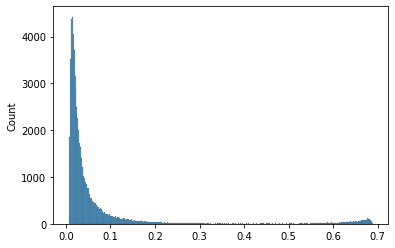

In [36]:
# контроль
seaborn.histplot( y_train )

# Применение

## Обучение на полном тесте

In [44]:
# model = linreg
model = cat

In [54]:
# нужно заново отмасштабировать, уже на всех данных, которые есть
scaler_final = StandardScaler()
                
X_final = X.copy()
X_final = X.copy()[:, f_imp]                    # берём только важные фичи
X_final = scaler_final.fit_transform(X_final)


Xt = Test.drop(columns=['y']).values
Xt = Xt[:, f_imp]                               # # берём только важные фичи
Xt = scaler_final.transform( Xt )

print(f"Xt.shape {Xt.shape[0]} , {Xt.shape[1]}")
Xt.mean()       # для контроля. должно быть что-то сравнимое с -0.004767676609021375

Xt.shape 1000 , 462


-0.004767676609021375

In [ ]:
# 3+ минуты
# заново обучить уже на всех данных
model.fit(X_final, convert_y( y ) )

In [70]:
# предсказание 
y_predt = model.predict(Xt) 
y_predt = inv_convert_y(y_predt)

# filename = f'submission{mae:.5}.csv'
note = 'refit-ypred'
# чтобы разлчиать файлы и примерно понимать с какими гиперпараметрами всего пайплайна они получены
filename = f'submission-f{Xt.shape[1]}-ypred_mean{y_predt.mean():.5f} {note}.csv'
np.savetxt(filename, y_predt)
filename

'submission-f462-ypred_mean0.04140 refit-ypred.csv'

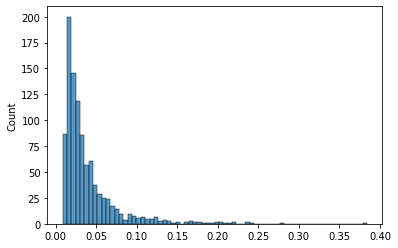

In [40]:
seaborn.histplot( y_predt )

## Hack

### Обучение на своих ответах для теста

In [69]:
# тут Треин всего 1/80 всего датасета. 
# поэтому такое переобучение помогает очень мало или почти не помогает
X_full = np.concatenate( [X_final, Xt], axis=0) 
Y_full = np.concatenate( [y, y_predt ] )

model.fit(X_full, convert_y( Y_full ) )

0:	learn: 0.7706522	total: 330ms	remaining: 5m 29s
1:	learn: 0.7625476	total: 600ms	remaining: 4m 59s
2:	learn: 0.7544986	total: 846ms	remaining: 4m 41s
3:	learn: 0.7469816	total: 1.08s	remaining: 4m 29s
4:	learn: 0.7398506	total: 1.35s	remaining: 4m 29s
5:	learn: 0.7328091	total: 1.61s	remaining: 4m 27s
6:	learn: 0.7261909	total: 1.87s	remaining: 4m 25s
7:	learn: 0.7196039	total: 2.12s	remaining: 4m 22s
8:	learn: 0.7132883	total: 2.38s	remaining: 4m 22s
9:	learn: 0.7073816	total: 2.63s	remaining: 4m 20s
10:	learn: 0.7018564	total: 2.89s	remaining: 4m 20s
11:	learn: 0.6962351	total: 3.14s	remaining: 4m 18s
12:	learn: 0.6909204	total: 3.4s	remaining: 4m 18s
13:	learn: 0.6861584	total: 3.65s	remaining: 4m 17s
14:	learn: 0.6814008	total: 3.89s	remaining: 4m 15s
15:	learn: 0.6766044	total: 4.14s	remaining: 4m 14s
16:	learn: 0.6720777	total: 4.41s	remaining: 4m 14s
17:	learn: 0.6675689	total: 4.66s	remaining: 4m 13s
18:	learn: 0.6632720	total: 4.91s	remaining: 4m 13s
19:	learn: 0.6593465	to

In [ ]:
# потом  запустить снова предсказание

# Блендинг
Объединим несколько хороших ответов, чтобы получить ответ ещё лучше.

Если ответы получены разными способами (например отлично число фич) то это немного помогает. 

In [ ]:
# submission0.059144.csv    - 0.06011 !!!!
# submission0.060185.csv    - 0.06061
# submission0.060232.csv    - 0.06038
# submission0.059286.csv    - 0.05984 !!
# submission0.059303.csv    - 0.05959 !
# submission_bl.csv         - 0.05988 !!!

In [65]:
# x1 = np.loadtxt('submission0.059303.csv')
# x2 = np.loadtxt('submission0.059286.csv')
# x3 = np.loadtxt('submission_bl.csv')
# x_bl = x1*0.4 + x2*0.25 + x3*0.2 + x4*0.15   # 0.05954


# x2 = np.loadtxt('submission1.5045e+20.csv')
# x1 = np.loadtxt('submission0.059303(1).csv')
# x_bl = x1*0.7 + x2*0.3  0.05906
                                                                # скор сайта
# x1 = np.loadtxt('submissiion-f570-ypred_mean0.04281.csv')     # 0.05792
# x2 = np.loadtxt('submission-f462-ypred_mean0.04130.csv')      # 0.05827
# x3 = np.loadtxt('submission-f339-ypred_mean0.04009.csv')      # 0.05937
# x_bl = x1*0.7 + x2*0.15 + x3*0.15                                 # 0.05799

# x1 = np.loadtxt('submissiion-f570-ypred_mean0.04281.csv')     # 0.05792
# x2 = np.loadtxt('submission-f462-ypred_mean0.04130.csv')      # 0.05827
# x3 = np.loadtxt('submission-f339-ypred_mean0.04009.csv')      # 0.05937
# x_bl = x1*0.5 + x2*0.25 + x3*0.25                               # 0.0581

x1 = np.loadtxt('submissiion-f570-ypred_mean0.04281.csv')     # 0.05792
x2 = np.loadtxt('submission-f462-ypred_mean0.04130.csv')      # 0.05827
x3 = np.loadtxt('submission-f339-ypred_mean0.04009.csv')      # 0.05937
x4 = np.loadtxt('submission0.059303.csv')                     # 0.05959 
# x_bl = x1*0.85 + x4*0.15    # 0.058
x_bl = x1*0.93 + x4*0.07    # 0.05794

In [66]:
filename = f'submission_bl-9.csv'
np.savetxt(filename, x_bl)
filename

'submission_bl-9.csv'

# Выводы (не полные, смотри текст)
**Модели**
- линейная регрессия на большом числе фич ( > ~ 160 увеличвает ошибку)
- бустинг хорош на большом числе фич
    - +даёт важность фич (feature importance)

**Данные**
- год и месяц отдельно
- число фич 163 + ОК
    - если больше, то уже стоит отбирать самые полезные фичи (feature importance)
    - отбор фич может дать 0.0003 (420 -> 100 )
    - но лучше отбирать из большего числа. даже если часть фич на 70% имеют забитые средним (медианой) пропуски
- добавлени числа NaN и выбросов помогает
- логарифмирование таргета: ln ( y ) -- помогает
- балансировка (любая: удаление большего класса, ADSIN, SMOTE) всё сильно портит


**Fuck**
- сравнивал MAE с логарифмированием таргета и без него, но забыл обратное преобразование. из-за этого MAE были несравнимы
- забывал преобразовать y для предсказания
- из-за непоследовательного запуска ячеек иногда записывал не ту инфу о гиперпараметрах импровизированного пайплайна. Нужно повторять всякую инфу в ячейках, чтобы не запутатся: 
    - число объектов
    - число фич
    - среднее иксов и предсказаний (могает отловить забытое масштабирование и т.п.)
    - распределение ответов (помогает отловить явную дичь)

# Результаты конкурса
```
место - username - результат (количество попыток)
1 - Aganov -           0.05634 (53)
2 - an4ouce -          0.05757 (9)
3 - pennyroyall111 -   0.05764 (28)
4 - alexandrkuvaev -   0.05772 (34)
                     # 0.5792 (куча попыток и времени)
5 - podviaznikoff -    0.05802 (5)
6 - vaskind96 -        0.05807 (53)
7 - FedotovDN -        0.05823 (45)
8 - ziliboba753 -      0.05829 (16)
9 - herzen -           0.0584 (11)
10 - vorsineo -        0.0584 (34)
11 - blackdeer1524 -   0.05841 (8)
12 - semyonyeliseyev - 0.05843 (25)
13 - lexboss777 -      0.05848 (42)
14 - alexbougaenko -   0.05849 (12)
15 - vitaly_po -       0.05853 (13)
16 - AndreyC -         0.0586 (31)
```
Подробнее здесь: https://open-data-battle.geecko.com/finalists

In [ ]:
# Для сравнения разных моделей и преобразований

# 163;  y = |pd - flg| -> np.log(y+1)
# мода, медиана; месяц; год
# linreg: 
# mae = 0.07862; mape = 7.86174; сайт = 0.07972
# catboost; GS {'depth': 6, 'iterations': 400, 'learning_rate': 0.1} max_iter = 1000
# mae = 0.06023; mape = 6.02320; cfqn = 0.06038

# 256 + outliers
#linreg; 
# mae = 0.07950; mape = 7.94976

# 256 + outliers
# catboost; GS
# mae = 0.05870; mape = 5.86978; site = 0.06125

# 256
# linreg
# mae = 0.14530; mape = 14.53029; 
# catboost; GS
# mae = 0.06018; mape = 6.01847; site = 0.06061

# catboost; GS1, {'depth': 6, 'iterations': 400, 'learning_rate': 0.1}; max_iter=3000
# mae = 0.06018; mape = 6.01847;

#  100 selected features
    # catboost; GS1, {'depth': 6, 'iterations': 400, 'learning_rate': 0.1}; max_iter=3000; od_wait=20
    # mae = 0.06011; mape = 6.01098

    # linreg: 
    # mae = 0.07893; mape = 7.89344

    # catboost; GS1, {'depth': 6, 'iterations': 400, 'learning_rate': 0.1}; max_iter=13000; od_wait=50
    # mae = 0.06011; mape = 6.01098

    # catboost; GS1, {'depth': 6, 'iterations': 400, 'learning_rate': 0.01}; max_iter=13000; od_wait=50;
    # mae = 0.06158; mape = 6.15819

    # catboost; GS1, {'depth': 6, 'iterations': 1000, 'learning_rate': 0.01}; max_iter=13000; od_wait=50;
    # mae = 0.06017; mape = 6.01657

    # 
    # catboost; GS1, {'depth': 6, 'iterations': 1000, 'learning_rate': 0.01}; max_iter=13000; od_wait=50;
    # mae = 0.06017; mape = 6.01657

# 255 features
# catboost; GS1, {'depth': 6, 'iterations': 1000, 'learning_rate': 0.01}; max_iter=13000; od_wait=50;
# mae = 0.06019; mape = 6.01900
    # select 100 features
    # linreg:   mae = 0.07915; mape = 7.91534
    # catboost: mae = 0.06039; mape = 6.03891; 0.06135
    # nan + 0.003


# 256 (nan, m, y) + outliers
# linreg: mae = 0.08027; mape = 8.02704
# cat:    mae = 0.06004; mape = 6.00411
    # 100 selected features
    # cat:                          site: 0.0613

# 420 (nan, m, y) + outliers
# linreg:       mae = 88.66119; mape = 8866.11935
# cat:          mae = 0.05914;  mape = 5.91444    site = 0.06042
    # 100 selected features
    # linreg:   mae = 0.15278;  mape = 15.27794
    # cat       mae = 0.05922;  mape = 5.92217   # site = 0.06011
    
        # GS: 'l2_leaf_reg': [1, 9, 20] -> 20
        #       mae = 0.05911; mape = 5.91132


# кажется тут ниже везде обучение на всех размеченных данных было для непреобразованного y!!!!

# тут всё без отбора фич
#ln( y + 1 )    +++
# {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 9, 'learning_rate': 0.1}
# 420
# cat: mae = 0.06048; mape = 6.04791
# {'depth': 6, 'iterations': 600, 'l2_leaf_reg': 9, 'learning_rate': 0.1}
# mae = 0.05929; mape = 5.92856        site ==    0.05984                       best-1
        # log categ_2, feat 962, 952, 960                                       =            
         # cat mae = 0.05930; mape = 5.93029    site = 0.05959                  best-1
            # 710 features; 
            # linreg: mae = 0.08556; mape = 8.55584
            # cat: mae = 0.05919; mape = 5.91854       site = 0.05971
                #  impute cat features [1,2,5,6,10,12, 17]                      не заменяло !!!                     =
                 # linreg: mae = 0.08539; mape = 8.53866
                 # cat:    mae = 0.05930; mape = 5.92986 site = 0.06049

                # impute: [1,5,6,10,12, 17]] + ['month', 'year']                не заменяло!!!           =+
                # linreg: mae = 0.08548; mape = 8.54795
                # cat:    mae = 0.05919; mape = 5.91854  site = 0.05971                      

                    # GSL depth = [4,6,8]; lr = 0.1, in = 2000, l2=[3,9,15]  35+мин   
                    # -> {'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 9, 'learning_rate': 0.1}
                    # cat: mae = 0.05938; mape = 5.93806    site = 0.05996
                        # select featuires_imp > 0.01 -> 597; no GS
                          # cat mae = 0.05938; mape = 5.93806   site = 0.06045
                # impute (default): [1,5,6,10,12, 17]] + ['month', 'year']; 
                 # {'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 9, 'learning_rate': 0.1}
                 # linreg: mae = 0.08542; mape = 8.54194
                 # cat:    mae = 0.05935; mape = 5.93464

# ! тперь для финально обучения используется covert_y ( y )
                 # linreg: mae = 0.08542; mape = 8.54194 (не должен был поменятся) 
                 # cat:    mae = 0.05935; mape = 5.93464 (не должен был поменятся) site =0.05956 (должен был поменятся)
                                                         # обучение без преобразования:  0.05995
                    # y = ln( y ) # без +1                                      ++++
                      # linreg: mae = 150446022975887605760.00000; mape = 15044602297588761231360.00000
                      # cat:                                                            site = 0.0586               # best2 (повторяемо)
                        # 934 feat;  (linreg падал)
                        # linreg: fail?
                        # cat:                               site = 0.05867
                      # 710 + outliers
                       # cat: site = 0.05881  
                        # переобучение на своих ответах
                         # cat site = 0.05878
                     # select featuires_imp > 0.01 -> 570 (после обучения на всём трейне)
                      # cat: site =  0.5792   (submissiion-f570-ypred_mean0.04281.csv)                              # best                                          best1                                      
                      # 710 + outliers 'iterations': 1000,
                        # cat site = 05881
                       # select featuires_imp > 0.01 -> 339
                        # cat   site 0.05937 (submission-f339-ypred_mean0.04009.csv)
                       # select featuires_imp > 0.005 -> 462
                        # cat   site 0.05827 (submission-f462-ypred_mean0.04130.csv)
                         # дообучение на своих ответах
                           # cat; site = 0.05816


#ln( y + 0 )    ----
# cat: mae = 0.05969; mape = 5.96885
# {'depth': 6, 'iterations': 600, 'l2_leaf_reg': 9, 'learning_rate': 0.1}
# cat: mae = 0.05874; mape = 5.87384    site = 0.95108                          !!

#ln( y + 0.1 ) # {'depth': 6, 'iterations': 600, 'l2_leaf_reg': 9, 'learning_rate': 0.1}
# cat: mae = 0.17....

# См. блендинг в конце